In [1]:
import pandas as pd
import numpy as np

COLLECTING DATA

In [2]:
cols = ['unit_no','time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range (1,22)]
train_df = pd.read_csv('train_FD001.txt', sep = ' ', names = cols, header = None, index_col =False)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_27112\4133541754.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_df = pd.read_csv('train_FD001.txt', sep = ' ', names = cols, header = None, index_col =False)


In [216]:
train_df.dropna(inplace=True)

In [3]:
test_df = pd.read_csv('test_FD001.txt', sep = ' ', names = cols, header = None, index_col =False)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_27112\2103499778.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  test_df = pd.read_csv('test_FD001.txt', sep = ' ', names = cols, header = None, index_col =False)


In [5]:
rul_df = pd.read_csv('RUL_FD001.txt',  header=None)

In [6]:
rul_df.columns =['RUL']

Preprocessing!!

In [7]:
max_cycle = train_df.groupby('unit_no')['time_in_cycles'].max().reset_index()
max_cycle.columns = ['unit_no', 'Max_cycle']


In [9]:
train_df = train_df.merge(max_cycle, on = 'unit_no', how ='left')

In [10]:
train_df['RUL'] = train_df['Max_cycle'] - train_df['time_in_cycles']

In [12]:
train_df.drop('Max_cycle', axis=1, inplace=True)

In [13]:
max_cycle_test = test_df.groupby('unit_no')['time_in_cycles'].max().reset_index()

In [14]:
max_cycle_test.columns=['unit_no', 'last_cycle']

In [16]:
rul_df['unit_no'] = max_cycle_test['unit_no']

In [17]:
rul_df['Max_cycle'] = rul_df['RUL'] + max_cycle_test['last_cycle']

In [19]:
test_df = test_df.merge(rul_df[['unit_no', 'Max_cycle']], on='unit_no', how='left')

In [21]:
test_df['RUL'] = test_df['Max_cycle'] - test_df['time_in_cycles']
test_df.drop('Max_cycle', axis=1, inplace=True)

In [239]:
train_df.drop('op_setting_3', axis=1, inplace=True)
test_df.drop('op_setting_3', axis=1, inplace=True)

In [22]:
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]

In [23]:
constant_sensors = train_df[sensor_cols].std() == 0

In [24]:
train_df.drop(columns=['sensor_1', 'sensor_5','sensor_16','sensor_10', 'sensor_6'], inplace = True)
test_df.drop(columns=['sensor_1', 'sensor_5','sensor_16','sensor_10', 'sensor_6'], inplace = True)

In [26]:
train_df.drop(columns=['sensor_18', 'sensor_19'], inplace = True)

In [27]:
test_df.drop(columns=['sensor_18', 'sensor_19'], inplace = True)

In [29]:
max_rul = 150
train_df['RUL_clipped'] = train_df['RUL'].clip(upper=max_rul)

In [30]:
max_rul = 150
test_df['RUL_clipped'] = train_df['RUL'].clip(upper=max_rul)

In [31]:
sensor_cols.remove('sensor_18')

In [32]:
sensor_cols.remove('sensor_19')


In [33]:
sensor_cols.remove('sensor_1')
sensor_cols.remove('sensor_5')
sensor_cols.remove('sensor_16')
sensor_cols.remove('sensor_10')
sensor_cols.remove('sensor_6')


In [35]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
scaler = MinMaxScaler()
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
test_df[sensor_cols] = scaler.transform(test_df[sensor_cols])
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)


Feature Engineering

In [40]:
top_features =  ['sensor_11', 'sensor_4', 'sensor_9', 'sensor_12', 'sensor_14', 'sensor_7', 'sensor_15', 'sensor_17', 'sensor_13', 'sensor_20', 'sensor_21']

In [41]:
window_sizes = [5, 10, 20]
for w in window_sizes:
    for s in top_features:  # e.g. ['sensor_11','sensor_4','sensor_9','sensor_12']
        train_df[f'{s}_mean_{w}'] = train_df.groupby('unit_no')[s].rolling(w).mean().reset_index(0,drop=True)
        train_df[f'{s}_std_{w}']  = train_df.groupby('unit_no')[s].rolling(w).std().reset_index(0,drop=True)
        train_df[f'{s}_min_{w}']  = train_df.groupby('unit_no')[s].rolling(w).min().reset_index(0,drop=True)
        train_df[f'{s}_max_{w}']  = train_df.groupby('unit_no')[s].rolling(w).max().reset_index(0,drop=True)
        train_df[f'{s}_skew_{w}'] = train_df.groupby('unit_no')[s].rolling(w).skew().reset_index(0,drop=True)
        test_df[f'{s}_mean_{w}'] = train_df.groupby('unit_no')[s].rolling(w).mean().reset_index(0,drop=True)
        test_df[f'{s}_std_{w}']  = train_df.groupby('unit_no')[s].rolling(w).std().reset_index(0,drop=True)
        test_df[f'{s}_min_{w}']  = train_df.groupby('unit_no')[s].rolling(w).min().reset_index(0,drop=True)
        test_df[f'{s}_max_{w}']  = train_df.groupby('unit_no')[s].rolling(w).max().reset_index(0,drop=True)
        test_df[f'{s}_skew_{w}'] = train_df.groupby('unit_no')[s].rolling(w).skew().reset_index(0,drop=True)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_27112\101129973.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{s}_max_{w}']  = train_df.groupby('unit_no')[s].rolling(w).max().reset_index(0,drop=True)
C:\Users\Harsh\AppData\Local\Temp\ipykernel_27112\101129973.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{s}_skew_{w}'] = train_df.groupby('unit_no')[s].rolling(w).skew().reset_index(0,drop=True)
C:\Users\Harsh\AppData\Local\Temp\ipykernel_27112\101129973.py:12: PerformanceWarning: DataFrame is highly 

In [42]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [48]:
X_train = train_df.drop(columns=['unit_no','time_in_cycles','RUL','RUL_clipped'])
y_train = train_df['RUL_clipped']

X_test = test_df.drop(columns=['unit_no','time_in_cycles','RUL','RUL_clipped'])
y_test = test_df['RUL_clipped']

LINEAR REGRESSION

In [43]:
from sklearn.linear_model import LinearRegression

In [49]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_linear = lr.predict(X_test)

In [50]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
print("mae", mean_absolute_error(y_test,y_pred_linear))
print("mse", mean_squared_error(y_test,y_pred_linear))
print("rmse", np.sqrt(mean_squared_error(y_test,y_pred_linear)))
print("r2_score", r2_score(y_test,y_pred_linear))

mae 21.786040264549985
mse 662.7383900624604
rmse 25.743705833901622
r2_score 0.7201661647433987


RANDOM FOREST

In [51]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state = 42)
rf.fit(X_train, y_train)
y_pred_random = rf.predict(X_test)

In [53]:
print("mae", mean_absolute_error(y_test,y_pred_random))
print("mse", mean_squared_error(y_test,y_pred_random))
print("rmse", np.sqrt(mean_squared_error(y_test,y_pred_random)))
print("r2_score", r2_score(y_test,y_pred_random))

mae 8.959694152113116
mse 177.13308088027128
rmse 13.30913524164028
r2_score 0.9252075477793394


XGBOOST


In [52]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgboost = xgb.predict(X_test)

In [54]:
print("mae", mean_absolute_error(y_test,y_pred_xgboost))
print("mse", mean_squared_error(y_test,y_pred_xgboost))
print("rmse", np.sqrt(mean_squared_error(y_test,y_pred_xgboost)))
print("r2_score", r2_score(y_test,y_pred_xgboost))

mae 5.3382792472839355
mse 47.99398422241211
rmse 6.927769065320532
r2_score 0.9797350764274597


LIGHT GBM

In [55]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)
lgb.fit(X_train, y_train)
y_pred_light_gbm = lgb.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40015
[LightGBM] [Info] Number of data points in the train set: 18731, number of used features: 181
[LightGBM] [Info] Start training from score 89.759116


In [146]:
print("mae", mean_absolute_error(y_test,y_pred_light_gbm))
print("mse", mean_squared_error(y_test,y_pred_light_gbm))
print("rmse", np.sqrt(mean_squared_error(y_test,y_pred_light_gbm)))
print("r2_score", r2_score(y_test,y_pred_light_gbm))

mae 5.139724551037684
mse 43.07621709568592
rmse 6.563247450438382
r2_score 0.9804833456192215


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [105]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

array([142, 141, 140, ...,  22,  21,  20], shape=(13096,))

array([145.1308719 ,  89.27456618,  78.794256  , ...,  16.78904709,
         8.80653456,   6.36027666], shape=(13096,))

NameError: name 'y_test_pred' is not defined

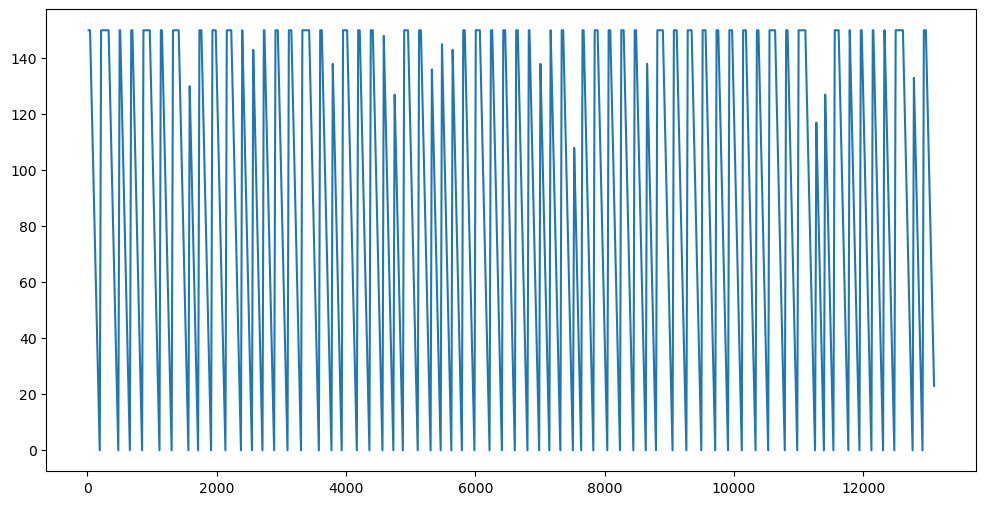

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test, label='True RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.xlabel('Time Step')
plt.ylabel('RUL')
plt.title('RUL Prediction vs True RUL')
plt.legend()
plt.show()


In [126]:
y_test


array([142, 141, 140, ...,  22,  21,  20], shape=(13096,))